In [1]:
""" 
Ordered response + PCA
"""

' \nOrdered response + PCA\n'

Motivation

* Background: Cancer has two stages - early and late # TODO: this needs a better interpretation, early and late are in the embedding space, not in the feature space

* Data: Source data is dense in early stage, but sparse in late stage. Target data is sparse in early stage, but dense in late stage.

* Question: Does transporting source representations onto target representations help with late stage cancer prediction?

* Note: This question is different from previous simulation questions. We only benchmark a subset of the source data; that is, data in the late stage.

Simulation

* Suppose the embedding dimension is 1.

* $r$ for indexing domains

* Let $[0, S]$ be early stage, and $(S, E]$ be late stage

* Let $N$ be the total number of data, $N_{se}$ be the number of data in early stage in the source data, and $N_{tl}$ be the number of data in late stage in the target data. Note that $N_{se}$ and $N_{tl}$ are supposed to be $> \frac{N}{2}$. Let $N_{te}'$ be the number of test data in the early stage of target data. Let $N_{tl}'$ be the number of test data in the late stage of target data. Note that $N_{te}' \approx N_{tl}'$.

* Simulate $X_{se} \sim \operatorname{Unif}\left( 0, S \right)$ where $|X_{se}| = N_{se}$

* Generate $Y_{se} = k_1 X_{se} + \epsilon$

* Simulate $X_{sl} \sim \operatorname{Unif}\left(S, E \right)$ where $|X_{sl}| = N-N_{se}$

* Generate $Y_{sl} = k_2 X_{sl} + \epsilon$

* Simulate $X_{te} \sim \operatorname{Unif}\left(0, S \right)$ where $|X_{te}| = N-N_{tl}$

* Generate $Y_{te} = k_1 X_{te} + \epsilon$

* Simulate $X_{tl} \sim \operatorname{Unif}\left(S, E \right)$ where $|X_{tl}| = N_{tl}$

* Generate $Y_{tl} = k_2 X_{tl} + \epsilon$

* The source representations are: $[X_{se}, X_{sl}]$. Source labels are $[Y_{se}, Y_{sl}]$. 

* The target representations are: $[X_{te}, X_{tl}]$. Target labels are $[Y_{te}, Y_{tl}]$. 

* Simulate $X_{te}' \sim \operatorname{Unif}\left(0, S \right)$ where $|X_{te}'| = N_{te}'$

* Generate $Y_{te}' = k_1 X_{te}' + \epsilon$

* Simulate $X_{tl}' \sim \operatorname{Unif}\left(S, E \right)$ where $|X_{tl}'| = N_{tl}'$

* Generate $Y_{tl}' = k_2 X_{tl}' + \epsilon$

* The test target representations are:  $[X_{te}', X_{tl}']$. Test target labels are $[Y_{te}', Y_{tl}']$. 

Expectation:

* Transport source data in its embedding space onto target domain embedding space can help with learning a better target model

* Use a single linear model to learn the mixture linear relationship



In [2]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")

from common import *
from math import floor, exp
from random import randint
from numpy.random import dirichlet
from numpy.random import poisson
from numpy.random import uniform
import numpy as np
from sklearn import preprocessing, linear_model
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from sklearn import metrics



In [3]:
""" 
Global parameter of this file
"""
pca = None

In [4]:
def make_func(k):
    """ 
    Make a linear function with coefficient k and intercept 0

    returns
        - the above described function
    """
    
    def f(x):
        return k*x
    return f 

In [5]:
def sample_X(x_num, low, high):
    """ 
    Sample x_num of x within [low, high]
    """
    return uniform(low=low, high=high, size=x_num)

def sample_y(X, k, random_state=None, nz=0.5):
    """
    Sample y based on y=kx+noise

    :param float nz: noise level
    """

    generator = check_random_state(random_state)

    f = make_func(k)
    y = [f(x) for x in X]
    # print("y in sample y is:", y)
    y = [each_y+ nz * generator.randn(1)[0] for each_y in y] # add random noise
    # print("y after noise is:", y)
    return y

In [6]:
def simulate_emb_label(num_patient, early_percent, k_1, low_1, high_1, nz_1,  k_2, low_2, high_2, nz_2):
    """ 
    Simulate desired early and late stage embeddings and labels (assume the embedding dimension is 1),
    for one domain

    :param int num_patient: number of patients
    :param float early_percent: percent for early stage patients, between 0 and 1
    :param float k_1: the desired coefficient for modeling the relationship between x and y in early stage
    :param int low_1: the lower bound for early stage data
    :param int high_1: the upper bound for early stage data
    :param float nz_1: the noise level for early stage data
    :param float k_2: the desired coefficient for modeling the relationship between x and y in late stage
    :param int low_2: the lower bound for late stage data
    :param int high_2: the upper bound for late stage data
    :param float nz_2: the noise level for late stage data
    """

    early_patient_num = floor(early_percent*num_patient)
    late_patient_num = num_patient-early_patient_num
    early_X = sample_X(early_patient_num, low_1, high_1)
    early_y = sample_y(early_X, k_1, nz=nz_1)
    late_X = sample_X(late_patient_num, low_2, high_2)
    late_y = sample_y(late_X, k_2, nz=nz_2)
    embs = np.append(early_X, late_X)
    embs = embs.reshape([embs.shape[0], 1])
    early_y.extend(late_y)
    labels = early_y
    return np.array(embs), np.array(labels)


In [7]:
""" 
Simulation scheme
"""

def simulate_pca_train(D, d_1, d_2, num_patient):
    """ 
    Simulate features and labels for domain 1 and domain 2, for PCA training
    :param int D:  total number of features
    :param int d_1: number of features with higher frequency in domain 1
    :param int d_2: number of features with higher frequency in domain 2
    :param int num_patient: number of patients in each domain

    Variables in the implementation are consistent with the variables in the scheme

    TODO: reconsider the choice of alpha_1 and alpha_2

    :return
        list[list[int]] domain 1 features
        list[int] domain 1 labels
        list[list[int]] domain 2 features
        list[int] domain 2 labels
    """

    d_1 = randint(0, floor(0.25*D))
    d_2 = randint(0, floor(0.25*D))
    
    unit_1 = 1/(2*d_1-2*d_2+3*D)
    alpha_1 = [5*unit_1]*d_1
    alpha_1.extend([unit_1]*d_2)
    alpha_1.extend([3*unit_1]*(D-d_1-d_2))
  
    unit_2 = 1/(-2*d_1+2*d_2+3*D)
    alpha_2 = [unit_2]*d_1
    alpha_2.extend([5*unit_2]*d_2)
    alpha_2.extend([3*unit_2]*(D-d_1-d_2))  
    W = np.random.normal(size=D)
    W  = [abs(W_k) for W_k in W] # only sample positive weights

    def gen_feature_vector_label(alpha):
        """ 
        Generate feature vectors and labels
        :param list[float] alpha: concentration parameteres for the dirichlet distribution
        """

        def sigmoid(x):
            return 1 / (1 + exp(-x))

        rho = dirichlet(alpha=alpha, size=1)[0]

        X = []
        Y = []
        b = 0
        all_sum = []

        for _ in range(num_patient):
            X_i = np.random.multinomial(len(rho), rho)
            for k in range(len(X_i)):
                if X_i[k] > 0:
                    X_i[k] = 1 # dominant effect
            X.append(X_i)
            cur_sum = np.sum(np.multiply(W, X_i))
            all_sum.append(cur_sum)
        
        # print("all_sum before preprocessing is:", all_sum)
        # standardize
        all_sum = preprocessing.scale(all_sum)
        # print("all_sum after preprocessing is:", all_sum)

        all_sum = np.array(all_sum)
        
        P = []
        for cur_sum in all_sum:
            p_i = sigmoid(cur_sum)
            P.append(p_i)
            Y_i = 0
            if p_i >= 0.5: # TODO: mimic exact logistic regression, change to np.random.binomial later
                Y_i = 1
            # Y_i = np.random.binomial(1, p_i) # too much noise, domain 1 data cannot learn well
            Y.append(int(Y_i))
        # print("P is:", P)

            
        return X, Y, W, b
    
    def feature_vector_to_feature(feature_vectors):
        """ 
        Convert feature vectors to features
        :param list[list[int]]: feature vectors consisting of indicators

        Returns
            - features consisting of actual codes
        """
        features = []
        for feature_vector in feature_vectors:
            features.append([i for i, e in enumerate(feature_vector) if e != 0])
        return features
    
    def pad_features(features_list):
        """ 
        Pad features to the same length (maximum length of the original features)\
            in each domain by -1
        """
        max_len = 0
        for features in features_list:
            max_len = max(max_len, len(features))

        for i in range(len(features_list)):
            features_list[i] += [-1] * (max_len - len(features_list[i]))
        return features_list



    feature_vector_1, label_1, W_1, b_1 = gen_feature_vector_label(alpha_1)
    feature_1 = pad_features(feature_vector_to_feature(feature_vector_1))
    feature_vector_2, label_2, W_2, b_2 = gen_feature_vector_label(alpha_2)
    feature_2 = pad_features(feature_vector_to_feature(feature_vector_2))
    return np.array(feature_1), label_1, np.array(feature_2), label_2



In [8]:
""" 
Wrapper function with different set ups for simulate()
"""
def simulate_pca_train_wrapper():
    num_patient = 1000
    D = 20
    d_1 = 8
    d_2 = 8
    return simulate_pca_train(D, d_1, d_2, num_patient)

In [9]:
def simulate_desired_emb_labels(num_patient):
    """ 
    Simulate desired target, test target and source desired embedding space and labels
    """
    train_target_features, train_target_labels, _, _ = simulate_pca_train_wrapper()
    global pca
    pca = PCA(n_components=1)
    pca.fit(train_target_features)
    early_percent = 0.9

    k_1 = 2
    k_2 = 1
    low_1 = 0
    high_1 = 100
    nz_1 = 1
    low_2 = 100
    high_2 = 200
    nz_2 = 2
    target_desired_reps, target_labels = simulate_emb_label(num_patient, early_percent, k_1, low_1, high_1, nz_1,  k_2, low_2, high_2, nz_2)

    early_percent = 0.5
    test_desired_reps, test_labels = simulate_emb_label(floor(num_patient/10), early_percent, k_1, low_1, high_1, nz_1,  k_2, low_2, high_2, nz_2) # test data in the target embedding space

    early_percent = 0.1
    nz_1 = 15
    nz_2 = 10
    source_desired_reps, source_labels = simulate_emb_label(num_patient, early_percent, k_1, low_1, high_1, nz_1,  k_2, low_2, high_2, nz_2)


    return target_desired_reps, target_labels, test_desired_reps, test_labels, source_desired_reps, source_labels


In [10]:
def simulate(num_patient):
    """ 
    Simulate target features, target labels, source features and source labels
    """
    
    target_desired_reps, target_labels, test_desired_reps, test_labels, source_desired_reps, source_labels = simulate_desired_emb_labels(num_patient)
    
    target_features = pca.inverse_transform(target_desired_reps)
    target_features = [[int(code) for code in inner] for inner in target_features]

    test_features = pca.inverse_transform(test_desired_reps)
    test_features = [[int(code) for code in inner] for inner in test_features]

    source_features = pca.inverse_transform(source_desired_reps)
    source_features = [[int(code) for code in inner] for inner in source_features]
    source_reps = pca.transform(source_features)
    return target_features, target_labels, test_features, test_labels, source_features, source_labels



In [11]:
def simulate_wrapper():
    return simulate(1000)

In [12]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, test_features):
    """ 
    Customized training algorithm for generating target representations and source representations
    
    :returns: target representations, source representations and test representations
    """
    global pca
    target_reps = pca.transform(target_features)
    source_reps = pca.transform(source_features)
    test_reps = pca.transform(test_features)

    return target_reps, source_reps, test_reps


In [13]:
""" 
One run with embedding space visualization
"""

' \nOne run with embedding space visualization\n'

In [14]:
train_target_features, train_target_labels, train_source_features, train_source_labels = simulate_pca_train_wrapper()

In [15]:
num_patient = 1000
target_desired_reps, target_labels, test_desired_reps, test_labels, source_desired_reps, source_labels = simulate_desired_emb_labels(num_patient)

In [16]:
trans_source_desired_reps = trans_source2target(source_desired_reps, target_desired_reps, max_iter=100000)

/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:484: RuntimeWarning: overflow encountered in true_divide
  v = b / KtransposeU
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 225
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [17]:
target_features, target_labels, test_features, test_labels, source_features, source_labels = simulate(num_patient)
# target_desired_reps = target_desired_reps.reshape([target_desired_reps.shape[0],1])
# target_features = pca.inverse_transform(target_desired_reps)
# target_features = [[int(code) for code in inner] for inner in target_features]
target_reps = pca.transform(target_features)

# source_desired_reps = source_desired_reps.reshape([source_desired_reps.shape[0],1])
# source_features = pca.inverse_transform(source_desired_reps)
# source_features = [[int(code) for code in inner] for inner in source_features]
source_reps = pca.transform(source_features)
test_reps = pca.transform(test_features)

# Sinkhorn Transport of source embedding into target embedding
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = trans_source2target(source_reps, target_reps)

/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:484: RuntimeWarning: overflow encountered in true_divide
  v = b / KtransposeU
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 223
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [18]:
target_clf = train_model(target_reps, target_labels)
aug_target_clf = train_model(np.append(target_reps, trans_source_reps, axis = 0), np.append(target_labels, source_labels, axis=0))

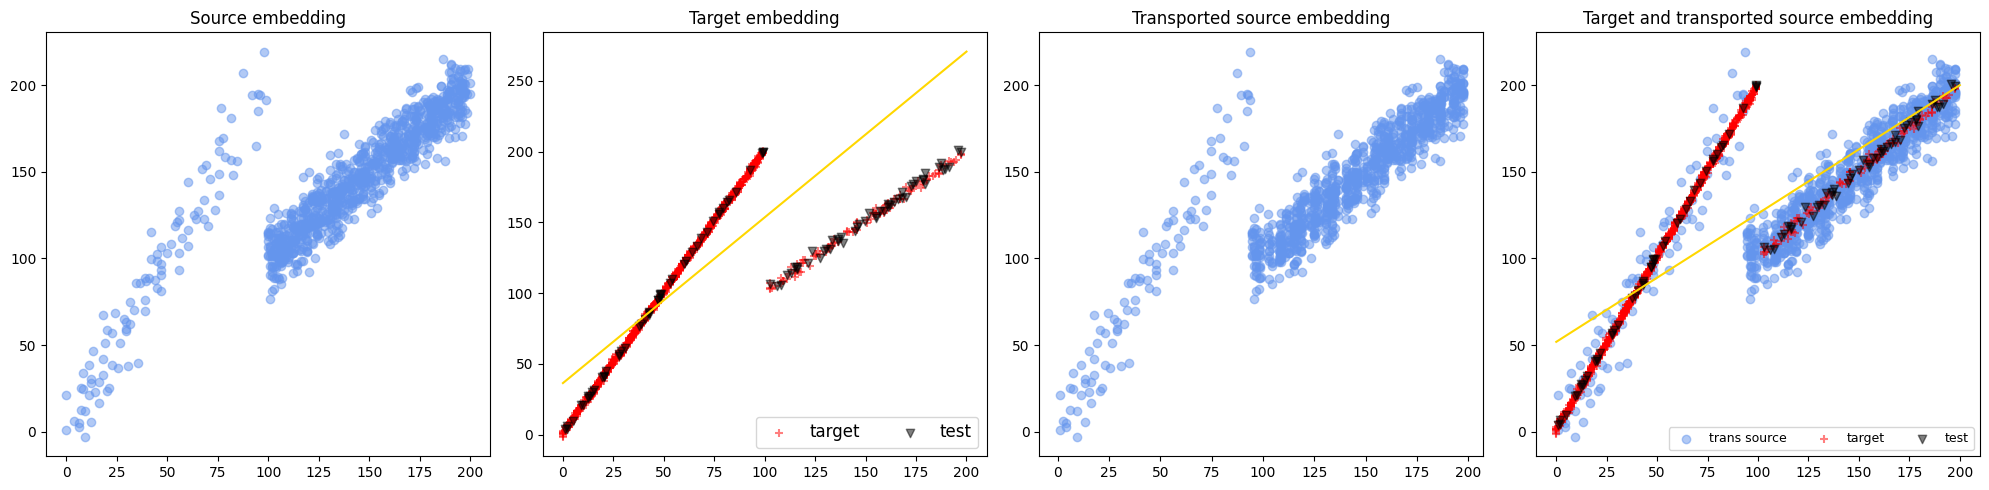

In [19]:
""" 
Visualize the actual embedding space
"""
vis_emb_dim1_ordered(target_reps, target_labels, source_reps, source_labels, trans_source_reps, test_reps, test_labels, target_clf, aug_target_clf)

In [20]:
target_maes, target_mses, target_rmses,  aug_target_maes, aug_target_mses, aug_target_rmses = \
    run_proc_multi_emb_ordered(simulate_wrapper, custom_train_reps, max_iter=100000, n_times = 10)

/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:485: RuntimeWarning: overflow encountered in true_divide
  u = 1. / nx.dot(Kp, v)
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 227
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:484: RuntimeWarning: overflow encountered in true_divide
  v = b / KtransposeU
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 198
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:485: RuntimeWarning: overflow encountered in true_divide
  u = 1. / nx.dot(Kp, v)
/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 210
  warnings.warn('Warning: numerical errors at iteration %d

In [21]:
scores_path = "../outputs/sim8_lr.csv"
save_scores_emb_ordered(target_maes, target_mses, target_rmses,  aug_target_maes, aug_target_mses, aug_target_rmses, scores_path)

average trans source to source mae is 56.2%
median trans source to source mae is 55.0%
average trans source to source rmse is 63.4%
median trans source to source rmse f1 is 62.4%


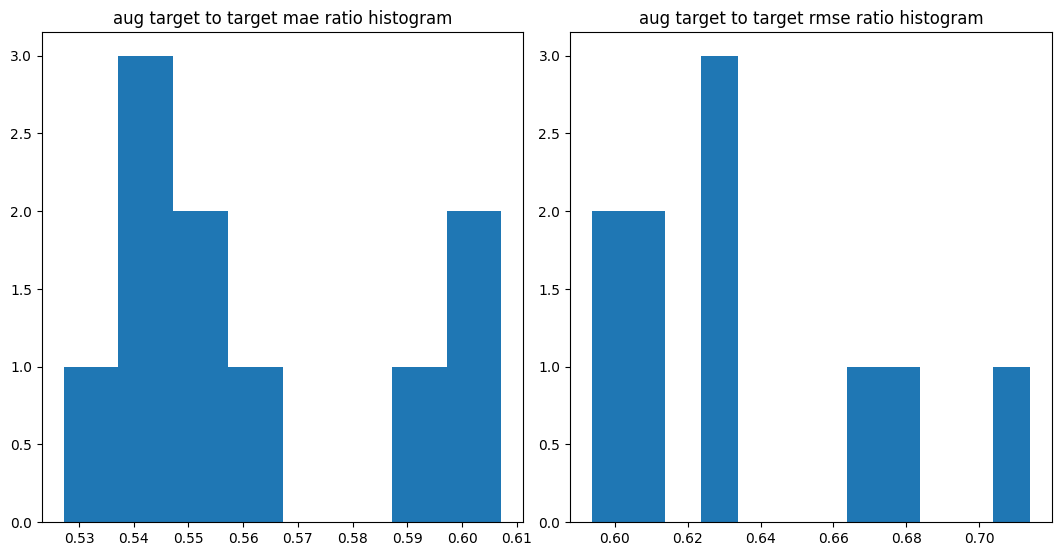

In [22]:
hist_plot_ordered_emb(scores_path)